In [200]:
import glob
from PIL import Image
import pillow_heif
import pandas as pd
import numpy as np
from torchvision.utils import save_image
import torchvision.transforms.functional as fn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [201]:
# generates new dataset by pasting beetles and non-beetles in the same picture. 
#returns array of new images and coordinates
#TODO: make sure that the beetles and non-beetles don't overlap with each other

def generate_data(bg: list[Image], beetle_set: list[Image], num_beetles_arr: list[int], 
                  non_beetle_set: list[Image], num_non_beetles_arr: list[int], overlap: bool):
    set_size = len(beetle_set)
    set_non_size = len(non_beetle_set)
    set_bg_size = len(bg)
    sim_arr, coords_arr = [],[]

    for i, num_beetles in enumerate(num_beetles_arr):
        num_non_beetles = num_non_beetles_arr[i]
        bg_id = np.random.randint(0, set_bg_size)
        bg_temp = bg[bg_id].copy()
        width, height = bg_temp.size
        beetle_coords = []
        non_beetle_coords = []
        for j in range(num_non_beetles):
            # get random non_beetle image
            non_beetle_id = np.random.randint(0, set_non_size)
            non_beetle_img = non_beetle_set[non_beetle_id]
            
            # get random non_beetle rotation
            angle = np.random.randint(0, 360)
            non_beetle_img = non_beetle_img.rotate(angle, resample=Image.BICUBIC, expand=1)
            
            non_beetle_width, non_beetle_height = non_beetle_img.size
            
            # get random x,y coords to paste non-beetle
            x = np.random.randint(0, width - non_beetle_width)
            y = np.random.randint(0, height - non_beetle_height)
            
            if not overlap:
                is_overlapping = True
                while (is_overlapping):
                    is_overlapping = False
                    for k in range(j):
                        _, x_, y_, width_, height_, _ = non_beetle_coords[-(k+1)]
                        if (x_ - width_/2) < x and (x_ + width_/2) > x and (y_ - height_/2) < y and (y_ + height_/2) > y:
                            is_overlapping = True
                            x = np.random.randint(0, width - non_beetle_width)
                            y = np.random.randint(0, height - non_beetle_height)
                            break

            bg_temp.paste(non_beetle_img, box=(x,y), mask=non_beetle_img)
            
            #centers x and y for YOLOv5 PyTorch label
            x += non_beetle_width/2
            y += non_beetle_width/2
            non_beetle_coords.append((non_beetle_id, x, y, non_beetle_width, non_beetle_height, angle))

            
        for j in range(num_beetles):
            # get random beetle image
            beetle_id = np.random.randint(0, set_size)
            beetle_img = beetle_set[beetle_id]
            # get random beetle rotation
            angle = np.random.randint(0, 360)
            beetle_img = beetle_img.rotate(angle, resample=Image.BICUBIC, expand=1)
            
            #randomly resize beetle to be smaller as they are much bigger on image
            
            beetle_width, beetle_height = beetle_img.size
            beetle_max = np.max([beetle_width, beetle_height])
            factor = np.random.uniform((height/(5*9))/beetle_max, (height/(4*9))/beetle_max)
            beetle_img = beetle_img.resize((int(factor * beetle_width), int(factor * beetle_height)), resample=Image.BICUBIC)
            beetle_width, beetle_height = beetle_img.size
            
            # get random x,y coords to paste beetle
            x = np.random.randint(0, width - beetle_width)
            y = np.random.randint(0, height - beetle_height)
            
            if not overlap:
                is_overlapping = True
                while (is_overlapping):
                    is_overlapping = False
                    for k in range(j+num_non_beetles):
                        if (k < num_non_beetles):
                            _, x_, y_, width_, height_, _ = non_beetle_coords[-(k+1)]
                        else:
                            _, x_, y_, width_, height_, _ = beetle_coords[-(k+1-num_non_beetles)]
                        if (x_ - width_/2) < x and (x_ + width_/2) > x and (y_ - height_/2) < y and (y_ + height_/2) > y:
                            is_overlapping = True
                            x = np.random.randint(0, width - non_beetle_width)
                            y = np.random.randint(0, height - non_beetle_height)
                            break
                            

            bg_temp.paste(beetle_img, box=(x,y), mask=beetle_img)
            
            #centers x and y for YOLOv5 PyTorch label
            x += beetle_width/2
            y += beetle_height/2
            beetle_coords.append((beetle_id, x, y, beetle_width, beetle_height, angle))
        sim_arr.append(bg_temp)
        coords_arr.append(beetle_coords)
    
    return sim_arr, coords_arr

In [202]:
#???
def find_coeffs(source_coords, target_coords):
    matrix = []
    for s, t in zip(source_coords, target_coords):
        matrix.append([t[0], t[1], 1, 0, 0, 0, -s[0]*t[0], -s[0]*t[1]])
        matrix.append([0, 0, 0, t[0], t[1], 1, -s[1]*t[0], -s[1]*t[1]])
    A = np.matrix(matrix, dtype=float)
    B = np.array(source_coords).reshape(8)
    res = np.dot(np.linalg.inv(A.T * A) * A.T, B)
    return np.array(res).reshape(8)

In [203]:
backgrounds = []
for file in glob.glob(r"/raid/projects/akhot2/group-01-phys371-sp2023/crop/cropped_imgs/*"):
    if "bg.png" in file: #clean trap
        bg = Image.open(file)
        # map corners of trap to corners of image
        coeffs = find_coeffs([(128,6), (1904,62), (2113,3137), (3,3228)], 
                     [(0,0), (bg.size[0], 0), (bg.size[0], bg.size[1]), (0, bg.size[1])])
        bg_flat = bg.transform(bg.size, Image.PERSPECTIVE, coeffs, Image.BICUBIC)
        backgrounds.append(bg)
        continue
    bg = Image.open(file)
    
    backgrounds.append(bg);

beetles = []
for file in glob.glob(r"/raid/projects/akhot2/group-01-phys371-sp2023/crop/beetles/*"):
    b0 = Image.open(file)
    beetles.append(b0);
non_beetles = []
for file in glob.glob(r"/raid/projects/akhot2/group-01-phys371-sp2023/crop/non_beetles/*"):
    n_b0 = Image.open(file)
    non_beetles.append(n_b0);

In [204]:
print(len(backgrounds))
print(len(beetles))
print(len(non_beetles))

21
20
48


In [188]:
beetle_counts = np.random.randint(0, 8, size=1250)
non_beetle_counts = np.random.randint(0, 15, size=1250)
overlap = True
sim_img_arr, coords_arr = generate_data(backgrounds, beetles, beetle_counts, non_beetles, non_beetle_counts, overlap)

In [189]:
#exports images and coordinates in YOLOv5 PyTorch format
def export(img_arr, coords_arr):
    s = ""
    image_set = "train"
    change = len(img_arr)*0.8
    for i in range(len(img_arr)):
        s = ""
        img = img_arr[i]
        for coord in coords_arr[i]:
            c, x, y, w, h, a = coord
            s += f"{0} {x/img.size[0]} {y/img.size[1]} {w/img.size[0]} {h/img.size[1]}\n"
        print(i)
        if i > change:
            image_set = "test"
        with open("data/" +image_set+ f"/labels/sim{i}.txt", "w") as f:
            f.write(s)
        img.save("data/" +image_set+ f"/images/sim{i}.png")

In [190]:
export(sim_img_arr, coords_arr)

0
1
2
3
4
5
6
7
8
9


In [20]:
beetle_counts.mean()

3.4648

In [22]:
non_beetle_counts.mean()

2.528

In [ ]:
format
0 x y width height (each value normalized to size of image)




RGBA
(2, 4)


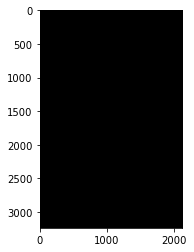

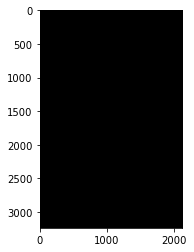

In [49]:
from torchvision.utils import draw_bounding_boxes
import torch
import torchvision
transform = transforms.Compose([transforms.ToTensor()])
for i in range(len(sim_img_arr)):
    print(sim_img_arr[i].mode)
    
    tensor = transform(sim_img_arr[i].convert("RGB")).type(torch.uint8)
    coords_list = np.zeros((len(coords_arr[i]), 4))
    j=0
    for k in coords_arr[i]:
        c, x, y, w, h, a = k
        coords_list[j, 0] = x
        coords_list[j, 1] = y
        coords_list[j, 2] = int(x+w)
        coords_list[j, 3] = int(y+h)
        j+=1
    print(coords_list.shape)
    draw_bounding_boxes(tensor, torch.Tensor(coords_list))
    plt.imshow(tensor.permute(1,2,0)[:,:,0:3])
    plt.show()
    break
    


First:
 - created 1250 images on a clean background variable 1 to 5 of the same beetle, model detected well on test set of 100 images (val/exp or exp2 or exp3) (proof of concept)
 
 fixed labels, making sure it's in the center
 
 - created 1250 images on a clean background variable 0 to 5 beetles of 6 different types of beetles, performing nearly 100%
 https://wandb.ai/akhot2/YOLOv5/runs/294etqct?workspace=user-fresleven
 https://wandb.ai/akhot2/YOLOv5/runs/i0ykd1a6?workspace=user-fresleven
 
TODO:
 - (fixed autocropping during rotation and added option for not overlapping and multiple backgrounds and non beetles)
 - created 1250 images on a clean background variable 0 to 7 beetles of 6 different images and 0 to 5 non-beetles 7 different images, performing 
 - created 1250 images on a clean and dirty background variables 0 to 15 beetles of 15 different images and 0 to 10 non-beetle of 10 different images, overlap True
 
 - created 1250 images on a clean and dirty background variables 0 to 10 beetles of 15 different images and 0 to 10 non-beetle of 10 different images, overlap False
 
 - perform auto cropping on arduino and include 

In [6]:
len(backgrounds)

4

In [196]:
import torch
model = torch.hub.load('ultralytics/yolov5', 'custom', '/raid/projects/akhot2/group-01-phys371-sp2023/yolov5_model/runs/train/20beetle_40-non_20dirt_bkg_overlap/weights/best.pt')
model.eval()

Using cache found in /home/akhot2/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-3-31 Python-3.9.12 torch-1.11.0 CUDA:0 (A100-SXM4-40GB, 40537MiB)

Fusing layers... 
Model summary: 212 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 48, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(96, 48, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(96, 48, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1))
  

In [199]:
model('/raid/projects/akhot2/group-01-phys371-sp2023/crop/data/train/images/sim1.png')

YOLOv5 <class 'models.common.Detections'> instance
image 1/1: 2746x1610 3 beetless
Speed: 125.2ms pre-process, 13.4ms inference, 1.1ms NMS per image at shape (1, 3, 640, 384)

In [153]:
width = []
height = []
for file in glob.glob('/raid/projects/akhot2/group-01-phys371-sp2023/crop/data/train/sim0.png'):
    print(file)
    n_b0 = Image.open(file)
    print(n_b0.size)
    w, h = n_b0.size
    width.append(w)
    height.append(h)
    #f = model(file)
    #print(f)

/raid/projects/akhot2/group-01-phys371-sp2023/crop/cropped_imgs/real18.jpg
(1744, 2778)
/raid/projects/akhot2/group-01-phys371-sp2023/crop/cropped_imgs/real16.jpg
(1894, 3155)
/raid/projects/akhot2/group-01-phys371-sp2023/crop/cropped_imgs/real7.jpg
(1837, 2978)
/raid/projects/akhot2/group-01-phys371-sp2023/crop/cropped_imgs/real8.jpg
(1680, 2791)
/raid/projects/akhot2/group-01-phys371-sp2023/crop/cropped_imgs/real10.jpg
(1880, 3101)
/raid/projects/akhot2/group-01-phys371-sp2023/crop/cropped_imgs/real13.jpg
(1572, 2582)
/raid/projects/akhot2/group-01-phys371-sp2023/crop/cropped_imgs/real15.jpg
(1486, 2422)
/raid/projects/akhot2/group-01-phys371-sp2023/crop/cropped_imgs/real6.jpg
(1635, 2699)
/raid/projects/akhot2/group-01-phys371-sp2023/crop/cropped_imgs/F28_3AUGUST2022_cropped.jpg
(1850, 2765)
/raid/projects/akhot2/group-01-phys371-sp2023/crop/cropped_imgs/bg.png
(2114, 3236)
/raid/projects/akhot2/group-01-phys371-sp2023/crop/cropped_imgs/real17.jpg
(1769, 3095)
/raid/projects/akhot2/

In [76]:
np.mean(width)

78.57894736842105

In [77]:
np.mean(height)

92.47368421052632

In [154]:
np.mean(width)

1723.5238095238096

In [155]:
np.mean(height)

2704.9523809523807

In [93]:
width[8]*.7

94.5

In [94]:
height[8]*.7

54.599999999999994

In [156]:
width

[1744,
 1894,
 1837,
 1680,
 1880,
 1572,
 1486,
 1635,
 1850,
 2114,
 1769,
 1751,
 1521,
 1640,
 1610,
 1662,
 1627,
 1548,
 1940,
 1494,
 1940]

In [166]:
for i in height:
    print((i/(6*9)))
    print((i/(7.5*9)))

51.44444444444444
41.15555555555556
58.425925925925924
46.74074074074074
55.148148148148145
44.11851851851852
51.68518518518518
41.34814814814815
57.425925925925924
45.94074074074074
47.81481481481482
38.25185185185185
44.851851851851855
35.88148148148148
49.98148148148148
39.98518518518519
51.2037037037037
40.96296296296296
59.925925925925924
47.94074074074074
57.31481481481482
45.851851851851855
48.72222222222222
38.977777777777774
42.7037037037037
34.162962962962965
42.388888888888886
33.91111111111111
50.851851851851855
40.681481481481484
51.24074074074074
40.992592592592594
39.907407407407405
31.925925925925927
40.5
32.4
50.24074074074074
40.19259259259259
49.907407407407405
39.925925925925924
50.24074074074074
40.19259259259259
